**Importing header files**

NLP

        

**assignment2**

NAMES

1.Ankit Raj 2211cs03
2.mukesh barpete 2211cs11
3.vickey jeshwani 2211cs19

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import random

**Reading data set from txt file line by line**

In [ ]:
with open (r"/content/NER-Dataset-Train.txt") as f:
    lines=f.readlines()

**"""SPlitting data into pairs of word-Tag form **

In [ ]:
lines[0]
pairs=[[]]
for i in lines:
    if i=='\n':
        pairs.append([])
        continue
    strip=i.strip('\n').split('\t')
    pairs[-1].append(strip)

pairs[0]

"""Create an HMM class having 4 methods.

1.   train
2.   viterbi
3.   test
4.   fivefold

In [ ]:
class HMM:
    def __init__(self,value,no_hidden_states=3):
        self.value=value
        self.no_hidden_states=no_hidden_states
        self.pi=np.ones((self.no_hidden_states),dtype='float64') # pi initial probabilities
        self.TMatrix=np.ones((self.no_hidden_states,self.no_hidden_states),dtype='float64') # Transision matrix for bigram
        self.UniqueWords=set()
        self.train_data=None
        self.UniqueTags=set()
        self.UniqueTags_to_numbers=dict()
        self.UniqueWords_to_numbers=dict()
        self.numbers_to_tags=dict()

    def train(self,train_data):
        train_data=[x for x in train_data if len(x)>3]
        for i in train_data:
            for ind,[j,k] in enumerate(i):
                self.UniqueTags.add(k)
                self.UniqueWords.add(j)
        self.UniqueWords.add('UNK') # Adding Unkown word
        self.EMatrix=np.ones((self.no_hidden_states,len(self.UniqueWords)),dtype='float64') # Emmision matrix
        self.UniqueWords,self.UniqueTags=list(self.UniqueWords),list(self.UniqueTags)
        self.UniqueTags_to_numbers={i:ind for ind,i in enumerate(self.UniqueTags)}
        self.UniqueWords_to_numbers={i:ind for ind,i in enumerate(self.UniqueWords)}
        self.numbers_to_tags={j:i for i,j in self.UniqueTags_to_numbers.items()}
        previous=None #Three pointers used to keep track of the pre  , current and next word
        next=None
        for i in train_data:
            for ind,[j,k] in enumerate(i):
                if ind==0:
                    self.pi[self.UniqueTags_to_numbers[k]]+=1
                    previous=k
                    continue
                next=k
                self.TMatrix[self.UniqueTags_to_numbers[previous]][self.UniqueTags_to_numbers[next]]+=1
                previous=next
                self.EMatrix[self.UniqueTags_to_numbers[k]][self.UniqueWords_to_numbers[j]]+=1
        self.pi=self.pi/self.pi.sum()
        self.TMatrix=self.TMatrix/self.TMatrix.sum(axis=1)[:,np.newaxis]
        self.EMatrix=self.EMatrix/self.EMatrix.sum(axis=1)[:,np.newaxis]


    def viterbi(self,words):
        matrix=np.zeros((len(words),self.no_hidden_states))-1e+4
        for j in words:
            if j not in self.UniqueWords_to_numbers:
                self.UniqueWords_to_numbers[j]=1
        matrix[0]=np.log(self.pi)*self.value+np.log(self.EMatrix[:,self.UniqueWords_to_numbers[words[0]]])
        for i in range(1,len(words)):
            for j in range(self.no_hidden_states):
                for k in range(self.no_hidden_states):
                    matrix[i][j]=max(matrix[i-1][k]*self.value+np.log(self.TMatrix[k][j])*\
                                     self.value+np.log(self.EMatrix[j][self.UniqueWords_to_numbers[words[i]]]),
                                                matrix[i][j] )
        resultseq=[]
        for i in np.argmax(matrix,axis=1):
            resultseq.append(self.numbers_to_tags[i])
        return resultseq


    def test(self,test_data):
        return_sequences=[]
        y_pred=[]
        y_true=[]
        for i in test_data:
            i=np.array(i)
            y_true+=[x for x in i[:,1]]
            y_pred+=self.viterbi(i[:,0])
        acc=np.count_nonzero(np.array(y_true)==np.array(y_pred))/len(y_true)
        return *precision_recall_fscore_support(y_pred,y_true,average='macro',zero_division=0),acc


    def FiveFold(self,data):
        index=int(len(data)/5)
        _=["Unigram Model","Bigram Model"]
        print(f"{'*'*60}\nFor {_[self.value]}\n")
        for i in range(5):
            train=data[0:index*i]+data[index*(i+1):]
            test=data[index*i:index*(i+1)]
            self.train(train)
            test_result=self.test(test)
            print(f"Precision {i+1}th fold="+str(round(test_result[0],2)),
                  f"\tRecall {i+1}th fold="+str(round(test_result[1],2)),
                  f"\tF1_score {i+1}th fold="+str(round(test_result[2],2)),
                  f"\tAccuracy {i+1}th fold="+str(round(test_result[-1],2)),"\n")
            self.__init__(self.value,self.no_hidden_states)

HMM for Bigram Model

In [ ]:
hmm_bigram=HMM(1)
hmm_bigram.FiveFold(pairs)

hmm_bigram.train(pairs)
hmm_bigram.TMatrix

hmm_bigram.EMatrix


"""HMM for Unigram Model

In [ ]:
hmm_unigram=HMM(0)
hmm_unigram.FiveFold(pairs)

"""Transmission Probabilities"""

In [ ]:
hmm_unigram.train(pairs)


"""Emission Probability""

In [ ]:
hmm_unigram.EMatrix

"""# RNN : Recurrent Neural Network
An RNN is a type of neural network that can process sequential data by maintaining a hidden state, which is updated at each time step using the input and the previous hidden state. The main features of an RNN are:

    Hidden state: The RNN maintains a hidden state that is updated at each time step and serves as a memory of the previous inputs.

    Time dependency: The output of the RNN at each time step depends not only on the current input but also on the previous inputs, through the hidden state.

    Parameter sharing: The same set of weights is used at each time step, which allows the network to learn to process sequential data of varying length.

Now, let's move on to the architecture of the RNN for NER tagging. The input to the network is a sequence of tokens, where each token is represented by a vector of features (e.g., word embedding, part-of-speech tag). The output of the network is a sequence of tags, where each tag represents the named entity label of the corresponding token.

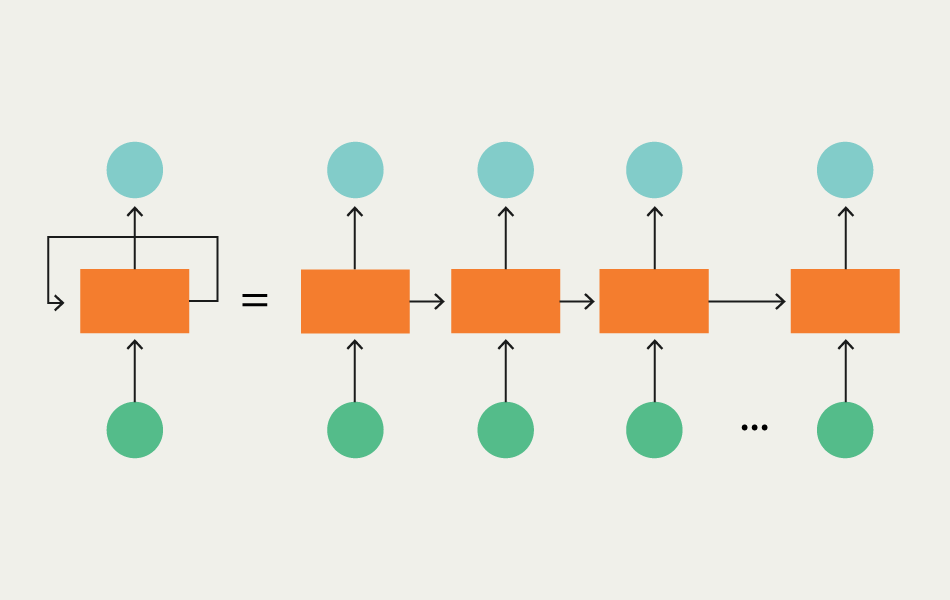

The architecture of the RNN for NER tagging is shown below:

      x1         x2         ...         xn
      |          |                     |
      V          V                     V
    [embedding] [embedding]  ...  [embedding]
      |          |                     |
      V          V                     V
    [RNN cell] [RNN cell]   ...  [RNN cell]
      |          |                     |
      V          V                     V
    [dense]    [dense]      ...  [dense]
      |          |                     |
      V          V                     V
      y1         y2         ...         yn

The input sequence of tokens is first passed through an embedding layer that converts each token into a vector of features. The embedded sequence is then fed into a sequence of RNN cells, each of which updates the hidden state based on the input and the previous hidden state. The output of each RNN cell is passed through a dense layer that maps the hidden state to a vector of scores for each possible tag. Finally, the sequence of tag scores is transformed into a sequence of tags using a softmax activation function.

The justification for this architecture is that it can effectively capture the sequential nature of the NER tagging task, as well as the context-dependent relationships between tokens and their corresponding named entity labels. By maintaining a hidden state and parameter sharing, the RNN can learn to process sequences of varying length and capture long-term dependencies between tokens. Additionally, the use of a dense layer allows the network to map the hidden state to a vector of scores for each tag, which can be used to make tag predictions for each token in the sequence.
"""